In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchsummary import summary
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


#Generate data list X1, Y, X20, X21

In [3]:
# x1: -10 to 10, step 0.25, 80 data points
# y = cubic function of x1
lstX1 = []
lstY1 = []
x = -10
while(x<10):
  y=3*x*x*x + 2*x*x + 5*x
  lstY1.append(y)
  lstX1.append(x)
  x = x + 0.25
print(len(lstX1), len(lstY1))

#normalized to [0,1]
lstX1= [(float(i)-min(lstX1))/(max(lstX1)-min(lstX1)) for i in lstX1]
lstY1= [(float(i)-min(lstY1))/(max(lstY1)-min(lstY1)) for i in lstY1]

80 80


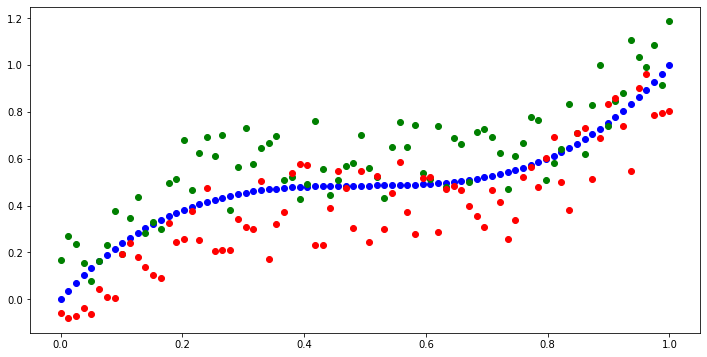

In [4]:
#for each x1, generate one data for class 0 and one data for class 1
#class 0: x2=y+random (above the cubic curve, green)
#class 1: x2=y-random (below the cubic curve, red)
lstX20 = []
lstX21 = []
for i in range(len(lstX1)): 
  lstX20.append(lstY1[i] + random.uniform(-0.1, 0.3))
  lstX21.append(lstY1[i] - random.uniform(-0.1, 0.3))
  
fig=plt.figure(figsize=(12, 6))
plt.scatter(lstX1, lstY1, color = "blue")
plt.scatter(lstX1, lstX20, color = "green")
plt.scatter(lstX1, lstX21, color = "red")
plt.show()

#Combine (x1, x20), (x1, x21) to generate X

In [5]:
lstX=[]
lstY=[]
for i in range(len(lstX1)):
  lstX.append([lstX1[i],lstX20[i]])
  lstY.append([0])
  lstX.append([lstX1[i],lstX21[i]])
  lstY.append([1])
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(160, 2) (160, 1)


In [6]:
trainX, testX, trainY_hat, testY_hat = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, trainY_hat.shape, testX.shape, testY_hat.shape)

(128, 2) (128, 1) (32, 2) (32, 1)


# Define NN

In [7]:
MyNet = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)
MyNet.to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.005)

In [8]:
BATCH_SIZE = 30
summary(MyNet, input_size=(BATCH_SIZE, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 30, 50]             150
              ReLU-2               [-1, 30, 50]               0
            Linear-3              [-1, 30, 100]           5,100
              ReLU-4              [-1, 30, 100]               0
            Linear-5               [-1, 30, 50]           5,050
              ReLU-6               [-1, 30, 50]               0
            Linear-7                [-1, 30, 1]              51
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


# Train with mini-batches

In [9]:
tensorX = torch.FloatTensor(trainX).to(device)
tensorY_hat = torch.FloatTensor(trainY_hat).to(device)
print(tensorX.shape, tensorY_hat.shape)

torch.Size([128, 2]) torch.Size([128, 1])


In [10]:
torch_dataset = Data.TensorDataset(tensorX, tensorY_hat)

In [11]:
loader = Data.DataLoader(
    dataset=torch_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,    # subprocesses for loading data
)

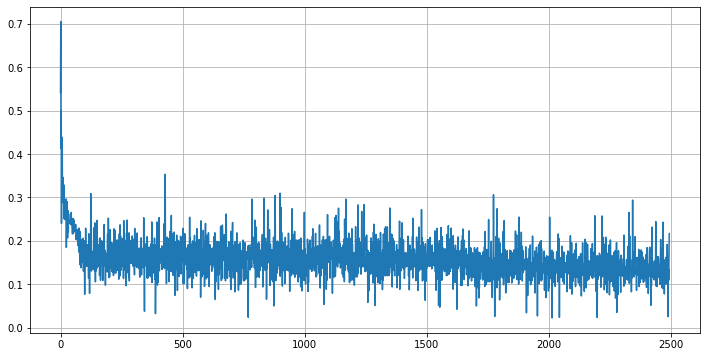

In [12]:
# initialize NN weights
for name, param in MyNet.named_parameters():
  if(param.requires_grad):
    torch.nn.init.normal_(param, mean=0.0, std=0.02)

lossLst = []
for epoch in range(1, 500):
  for (batchX, batchY_hat) in loader:
    tensorY = MyNet(batchX)
    loss = loss_func(batchY_hat, tensorY)
    lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
fig=plt.figure(figsize=(12, 6))
plt.plot(lossLst)
plt.grid()
plt.show()

# Test performance

In [13]:
tensorX = torch.FloatTensor(testX).to(device)
tensorY_hat = torch.FloatTensor(testY_hat).to(device)
tensorY = MyNet(tensorX)
loss = loss_func(tensorY, tensorY_hat)
print("Test loss: %.2f" % (float(loss)))
Y = tensorY.detach().cpu().numpy()
print("min y = ", np.min(Y), ", max y =", np.max(Y))

Test loss: 0.15
min y =  -0.018741965 , max y = 1.0456767


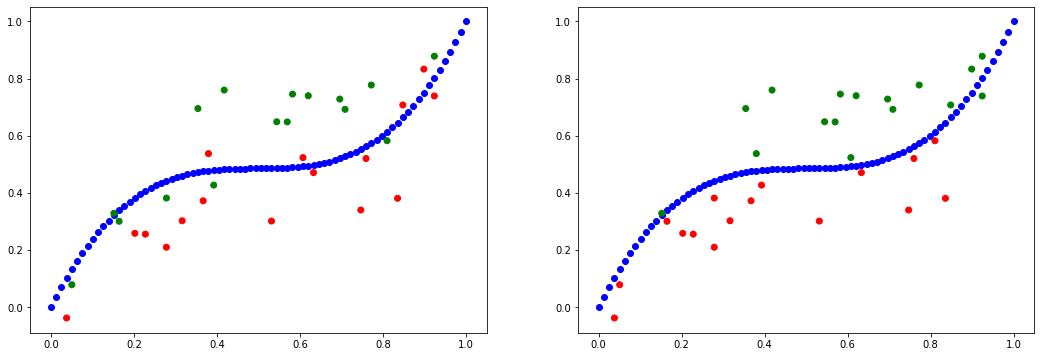

correct No.= 22 , accuracy =  0.6875


In [14]:
# show original classification
fig=plt.figure(figsize=(18, 6))
lstColor = []
for i in range(testY_hat.size):
  if(testY_hat[i][0]==0):
    lstColor.append("green")
  else:
    lstColor.append("red")
fig.add_subplot(1, 2, 1) 
plt.scatter(lstX1, lstY1, color = "blue")
plt.scatter(testX[:, 0], testX[:, 1], c=lstColor)

# show model predicted classification
lstColor = []
correctNo = 0
for i in range(Y.size):
  if(Y[i][0]<=0.5):
    lstColor.append("green")
    if(testY_hat[i][0]==0):
      correctNo = correctNo + 1
  else:
    lstColor.append("red")
    if(testY_hat[i][0]==1):
      correctNo = correctNo + 1  
accuracy = correctNo/Y.size
fig.add_subplot(1, 2, 2) 
plt.scatter(lstX1, lstY1, color = "blue")
plt.scatter(testX[:, 0], testX[:, 1], c=lstColor)
plt.show()
print("correct No.=", correctNo, ", accuracy = ", accuracy)

# Collect variance of model's predicting errors

In [15]:
lossLst = []
accuracyLst = []

for i in range(10): #randomly split data N times
  print(i+1, end = " ,")
  trainX, testX, trainY_hat, testY_hat = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY_hat = torch.FloatTensor(trainY_hat).to(device)

  # define loader for mini-batch training
  torch_dataset = Data.TensorDataset(tensorX, tensorY_hat)
  loader = Data.DataLoader(
      dataset=torch_dataset,  
      batch_size=BATCH_SIZE,      
      shuffle=True,       
      num_workers=0,    
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)

  # train NN
  for epoch in range(1, 200):
    for (batchX, batchY_hat) in loader:
      tensorY = MyNet(batchX)
      loss = loss_func(batchY_hat, tensorY)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # after training, get test performance
  tensorX = torch.FloatTensor(testX).to(device)
  tensorY_hat = torch.FloatTensor(testY_hat).to(device)
  tensorY = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  lossLst.append(float(loss))

  Y = tensorY.detach().cpu().numpy()
  correctNo = 0
  for i in range(Y.size):
    if((Y[i][0]<=0.5 and testY_hat[i][0]==0) or
      (Y[i][0]>0.5 and testY_hat[i][0]==1)):
      correctNo = correctNo + 1  
  accuracy = correctNo/tensorY.shape[0]
  accuracyLst.append(accuracy)

1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,

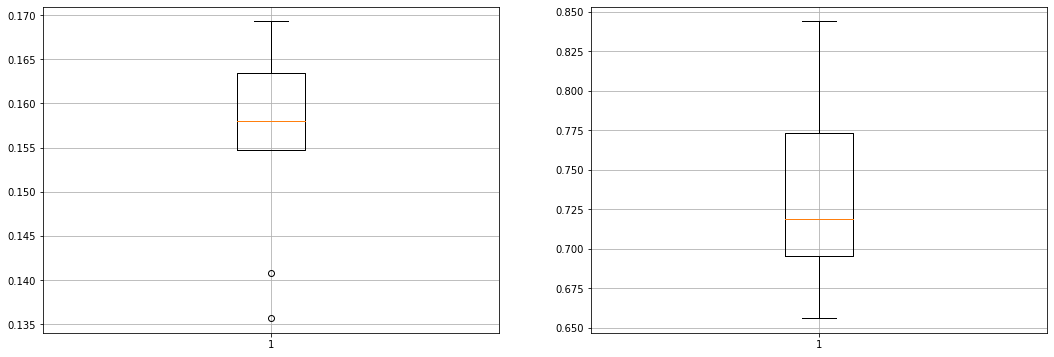

In [16]:
fig=plt.figure(figsize=(18, 6))
fig.add_subplot(1, 2, 1) 
plt.boxplot(lossLst)
plt.grid()

fig.add_subplot(1, 2, 2) 
plt.boxplot(accuracyLst)
plt.grid()
plt.show()